In [1]:
using JLD2
using CairoMakie

#file = open("barotropic_packets.jld2")
#close(file)

In [3]:
include("../analysis/load_file.jl")
#t1, x1, k1, u1 = load_packet_analysis_file("raytracing_data/packets_U=0.63.jld2", true)
t1, x1, k1, u1 = load_packet_analysis_file("packets_N400_1.jld2", true)
#t3, x3, k3, u3 = load_packet_analysis_file("packets_3.jld2", true)

([0.0; 2.4543692606170353; … ; 2000.310947399852; 2002.765316660465;;], [-2.9845130209103035 -2.9845130209103035 … 2.9845130209103035 2.9845130209103035; -1.0149533693656427 -0.8733910480534769 … 4.986916331374592 4.912598955956015; … ; 62.6813828743666 -92.81729160693966 … 275.82999636318965 141.2944435386649; 61.508659801640555 -91.55970105103113 … 276.8089886906171 140.89673911956763;;; -2.9845130209103035 -2.670353755551324 … 2.670353755551324 2.9845130209103035; -2.6049884496134 -2.705037097436259 … 3.1063603500946546 2.2180019070169106; … ; -66.45868510793797 123.95608887290193 … 107.10439105814184 75.53487212836069; -65.72453824284588 125.84741460571588 … 105.32986362001542 73.22575853465875], [1.7318371287591097 1.731196145051856 … 1.7318371287591097 1.7320508075688772; 1.8817075151600116 1.5961545357853586 … 1.5748743873154156 1.7726742347660291; … ; -0.5494617985185907 3.55118184617591 … 5.074614047125083 -0.044086557919161294; -0.56005057327033 3.19385503021323 … -0.26023307

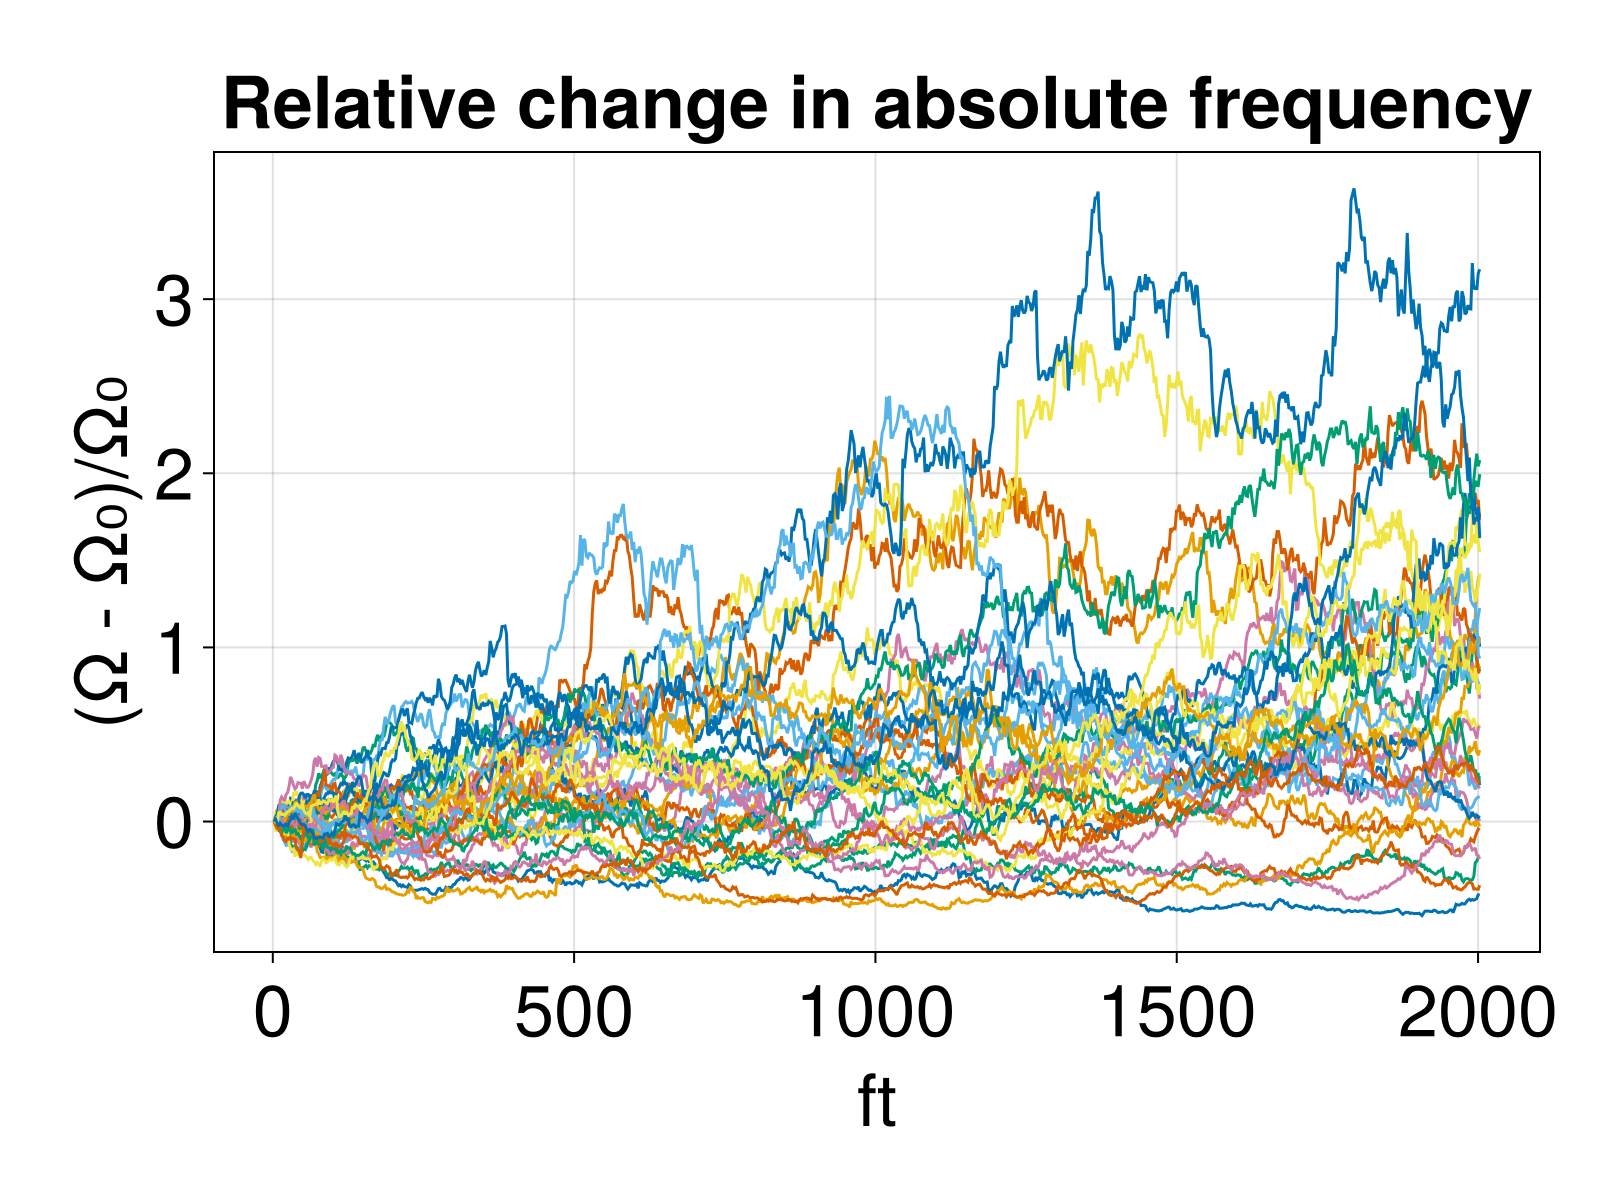

In [4]:
Ω = sqrt.(1 .+ (k1[:,:,1].^2 + k1[:,:,2].^2)) + sum(u1 .* k1, dims=3)[:,:,1]
Ω = Ω[2:end, :]
fig2 = Figure(size=(800, 600), fontsize = 36, figure_padding = 30)
ax2 = Axis(fig2[1, 1]; 
        title = "Relative change in absolute frequency", xlabel="ft", ylabel="(Ω - Ω₀)/Ω₀"
        #limits = ((0, maximum(t1)), (-1., 5.))
)
for i=1:36
    initial_omega = Ω[1,i]
    lines!(ax2, t1[2:end], (Ω[:, i] .- initial_omega) / initial_omega)
end

#save("QG_absolute_frequency.png", fig2)
fig2

In [27]:
sqrt(sum(u1[end,:,1].^2)) / 625

0.0002232882164962351

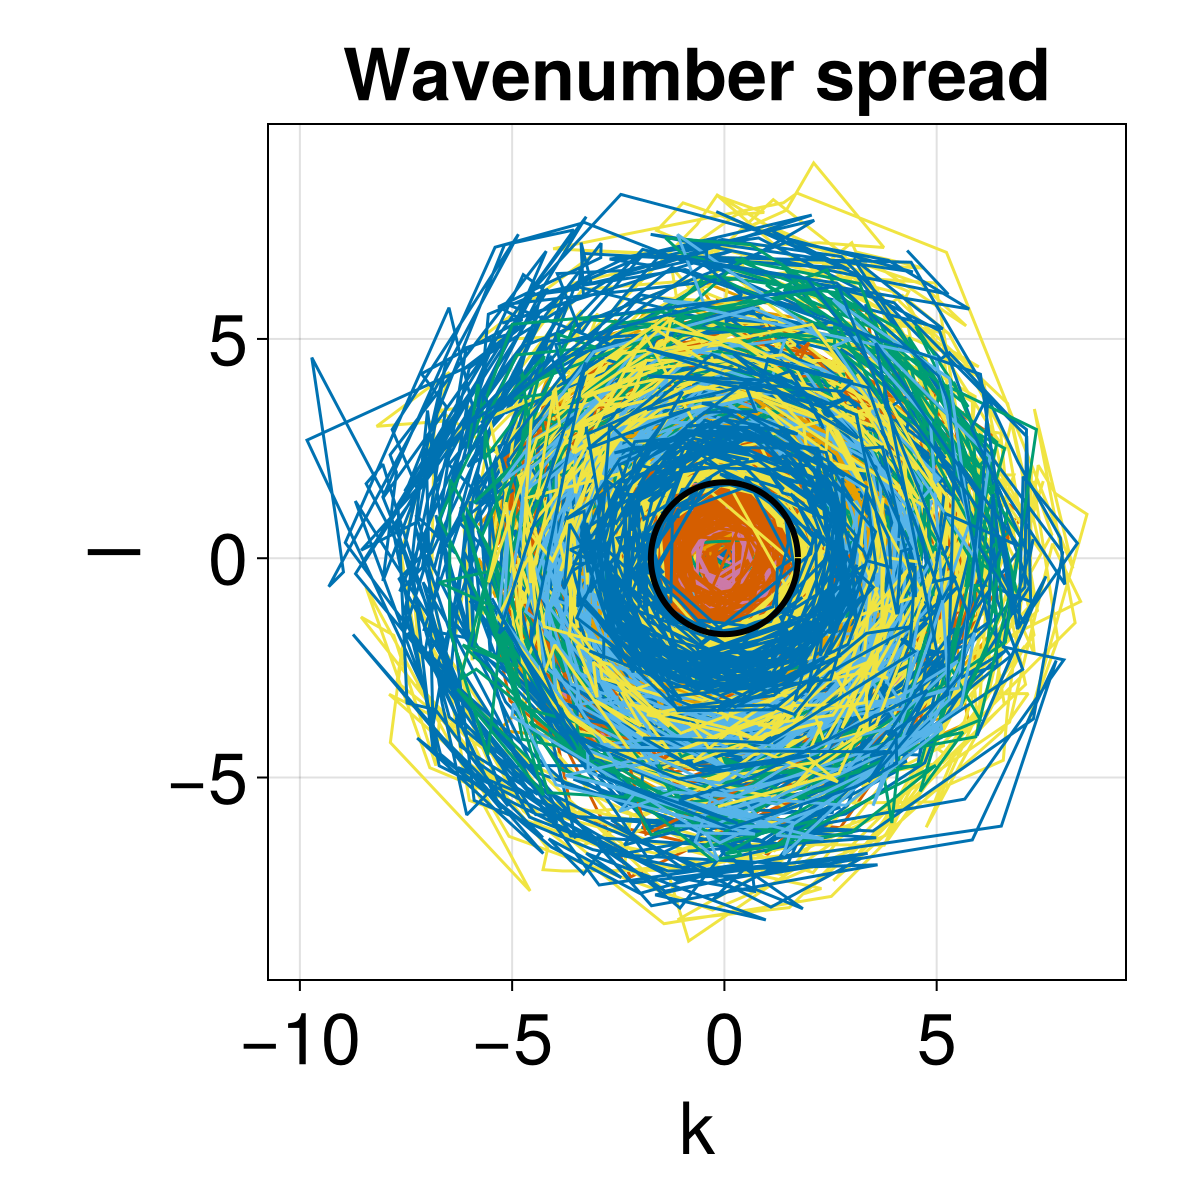

In [5]:
fig1 = Figure(size=(600, 600), fontsize=36)
ax1 = Axis(fig1[1, 1]; title = "Wavenumber spread", xlabel="k", ylabel="l", aspect=1)
for i=1:36
    lines!(ax1, k1[:,i,1], k1[:,i,2])
end
lines!(ax1, k1[1,:,1], k1[1,:,2], color="black", linewidth=3)

#save("QG_wavenumber_spread.png", fig1)
fig1

37
37


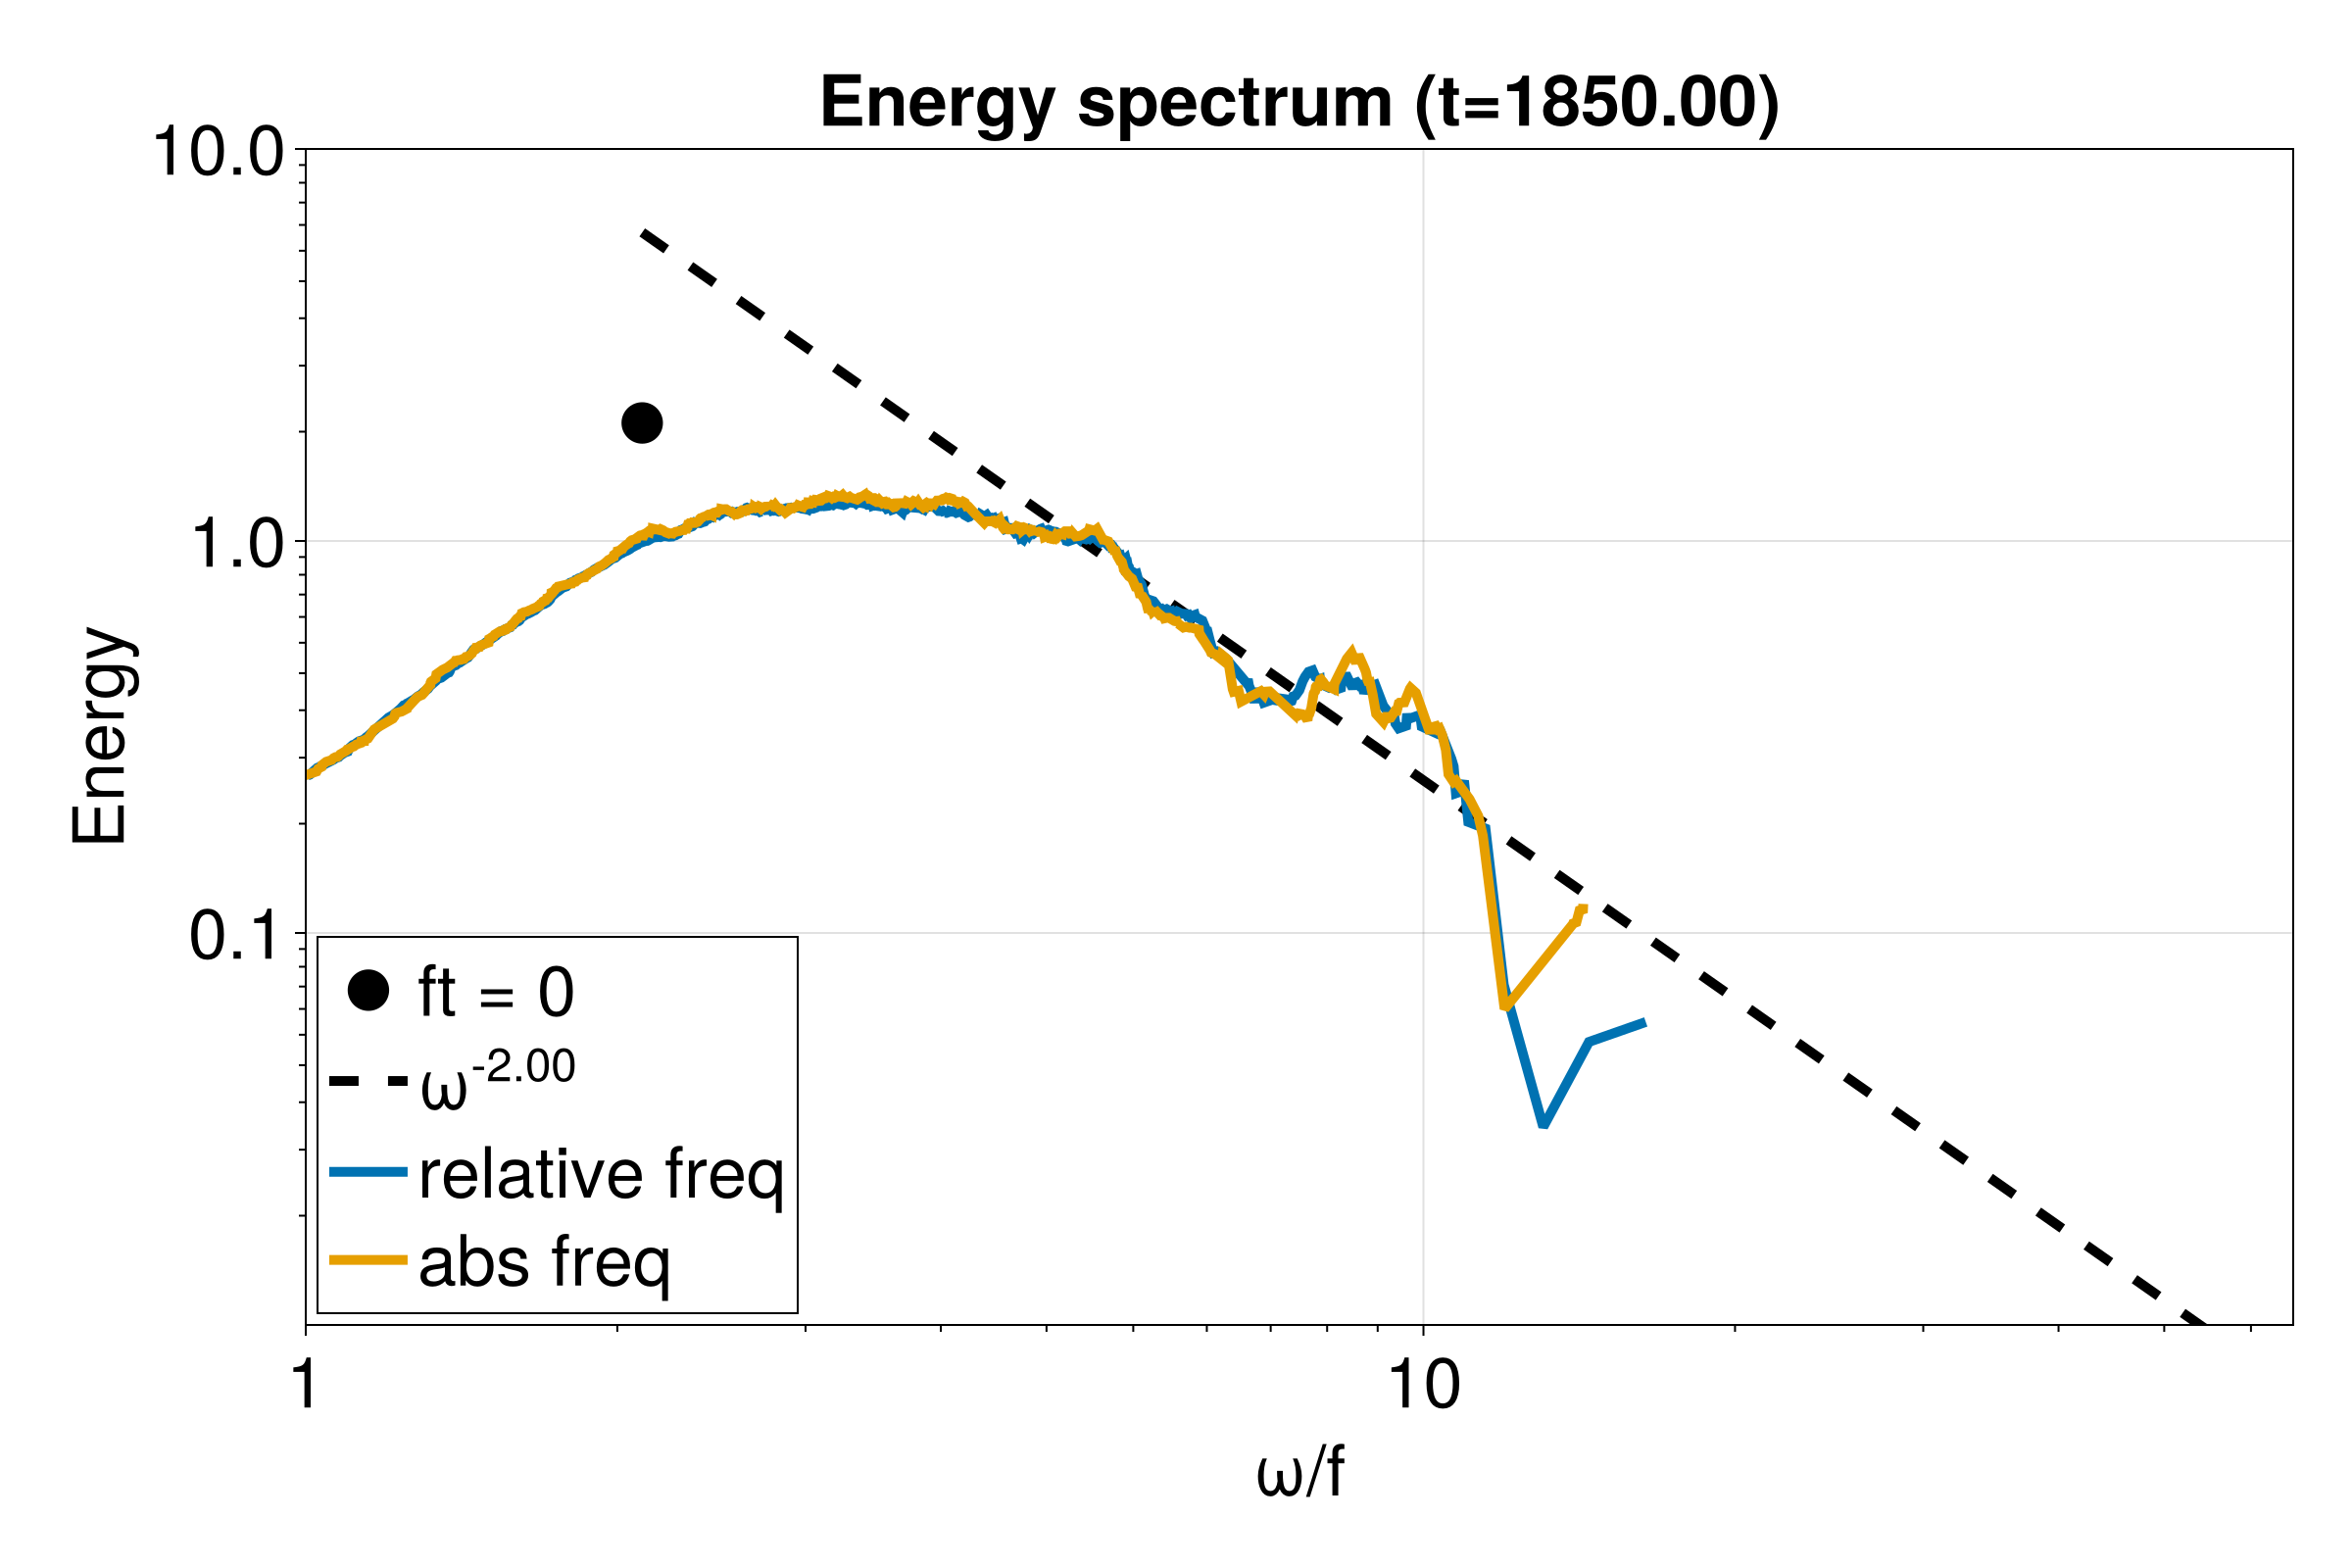

In [7]:
t = t1
k = k1
u = u1

ω  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω₀ = @. sqrt(1 + (k[1,:,1]^2 + k[1,:,2]^2))# + u[1,:,1]*k[1,:,1] + u[1,:,2]*k[1,:,2]
ω_abs  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]

function find_index(time, t, size)
    idx = findfirst(x -> x >= (time), t)[1]
    return idx - Int(floor(size/2))
end

function compute_energy(fω, start, fin, step)
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
end

using Printf
title = Observable(@sprintf("Energy spectrum (t=%.2f)", 0.))
fig3 = Figure(size=(1200, 800), fontsize=36, figure_padding=30)
ax3 = Axis(fig3[1, 1], xscale = log10, yscale = log10, 
        title = title,
        xlabel = "ω/f",
        ylabel = "Energy",
        limits = ((1, 60), (1e-2, 10)),
        yticks = [0.1, 1., 10.],
        xminorticks = IntervalsBetween(10),
        xminorticksvisible=true,
        yminorticks = IntervalsBetween(10),
        yminorticksvisible=true,
        xticks = ([1, 10, 100], ["1", "10", "100"]))
start_w = 2
fin_w = 60
ω_trend = start_w:0.5:fin_w
# slope = -2.25
slope = -2.00
trend = ω₀[1]*(1/3.5)^(slope)*ω_trend.^(slope)

N_lines = 1
#desired_times = [100., 300., 600., 900., 1200., 1500., 1800., 2100., 2400., 2700.]

#desired_times = [2900.]
step_end = 1
get_index(time) = find_index(time, t, step_end)
#starts = get_index.(desired_times)
#starts = [1, 10000, 30000, 50000, 70000]
#ends = starts .+ step_end
step = 1

initial_value_dot = scatter!(ax3, ω₀[1], ω₀[1], color="black", label="ft = 0", markersize=30, marker=:circle)
translate!(initial_value_dot, 0, 0, 1)

time_step = 50
frames = 1:floor(Int, (maximum(t)-100) / time_step-1)
println(frames[end])
lines!(ax3, ω_trend, trend, color="black", linestyle=:dash, label=rich("ω", superscript(@sprintf("%.2f", slope))); linewidth=5)
fω_plot = Observable([1.])
fω_abs_plot = Observable([1.])
energy_plot = Observable([1.])
energy_abs_plot = Observable([1.])
lines!(ax3, fω_plot, energy_plot, xscale=:log10, yscale=:log10; linewidth=5, label="relative freq")#, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
lines!(ax3, fω_abs_plot, energy_abs_plot, xscale=:log10, yscale=:log10; linewidth=5, label="abs freq")#, linestyle=:dash, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
axislegend(ax3, position=:lb, patchsize=(40., 20.))
println(length(frames))
CairoMakie.record(fig3, "spectrum_movie_U=0.1.mp4", frames, framerate = 18) do j
    desired_time =  j*time_step
    get_index(time) = find_index(desired_time, t, step_end)
    start = get_index(desired_time)
    ei = start + step_end
    #start = starts[i]
    #ei = ends[i]
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
    energy = (fω .* sum(mask,dims=2))[:] / length(fω)
    fω_abs = sort(ω_abs[start:step:ei,:][:])
    mask = (fω_abs' .>= (fω_abs .- 1)) .* (fω_abs' .<= (fω_abs .+ 1))
    energy_abs = (fω .* sum(mask,dims=2))[:] / length(fω_abs)
    
    fω_plot[] = fω
    fω_abs_plot[] = fω_abs
    energy_plot[] = energy
    energy_abs_plot[] = energy_abs
    title[] = @sprintf("Energy spectrum (t=%.2f)", desired_time)
end


save("energy_plot_barotropic_U=0.1.png", fig3)
fig3

7
7


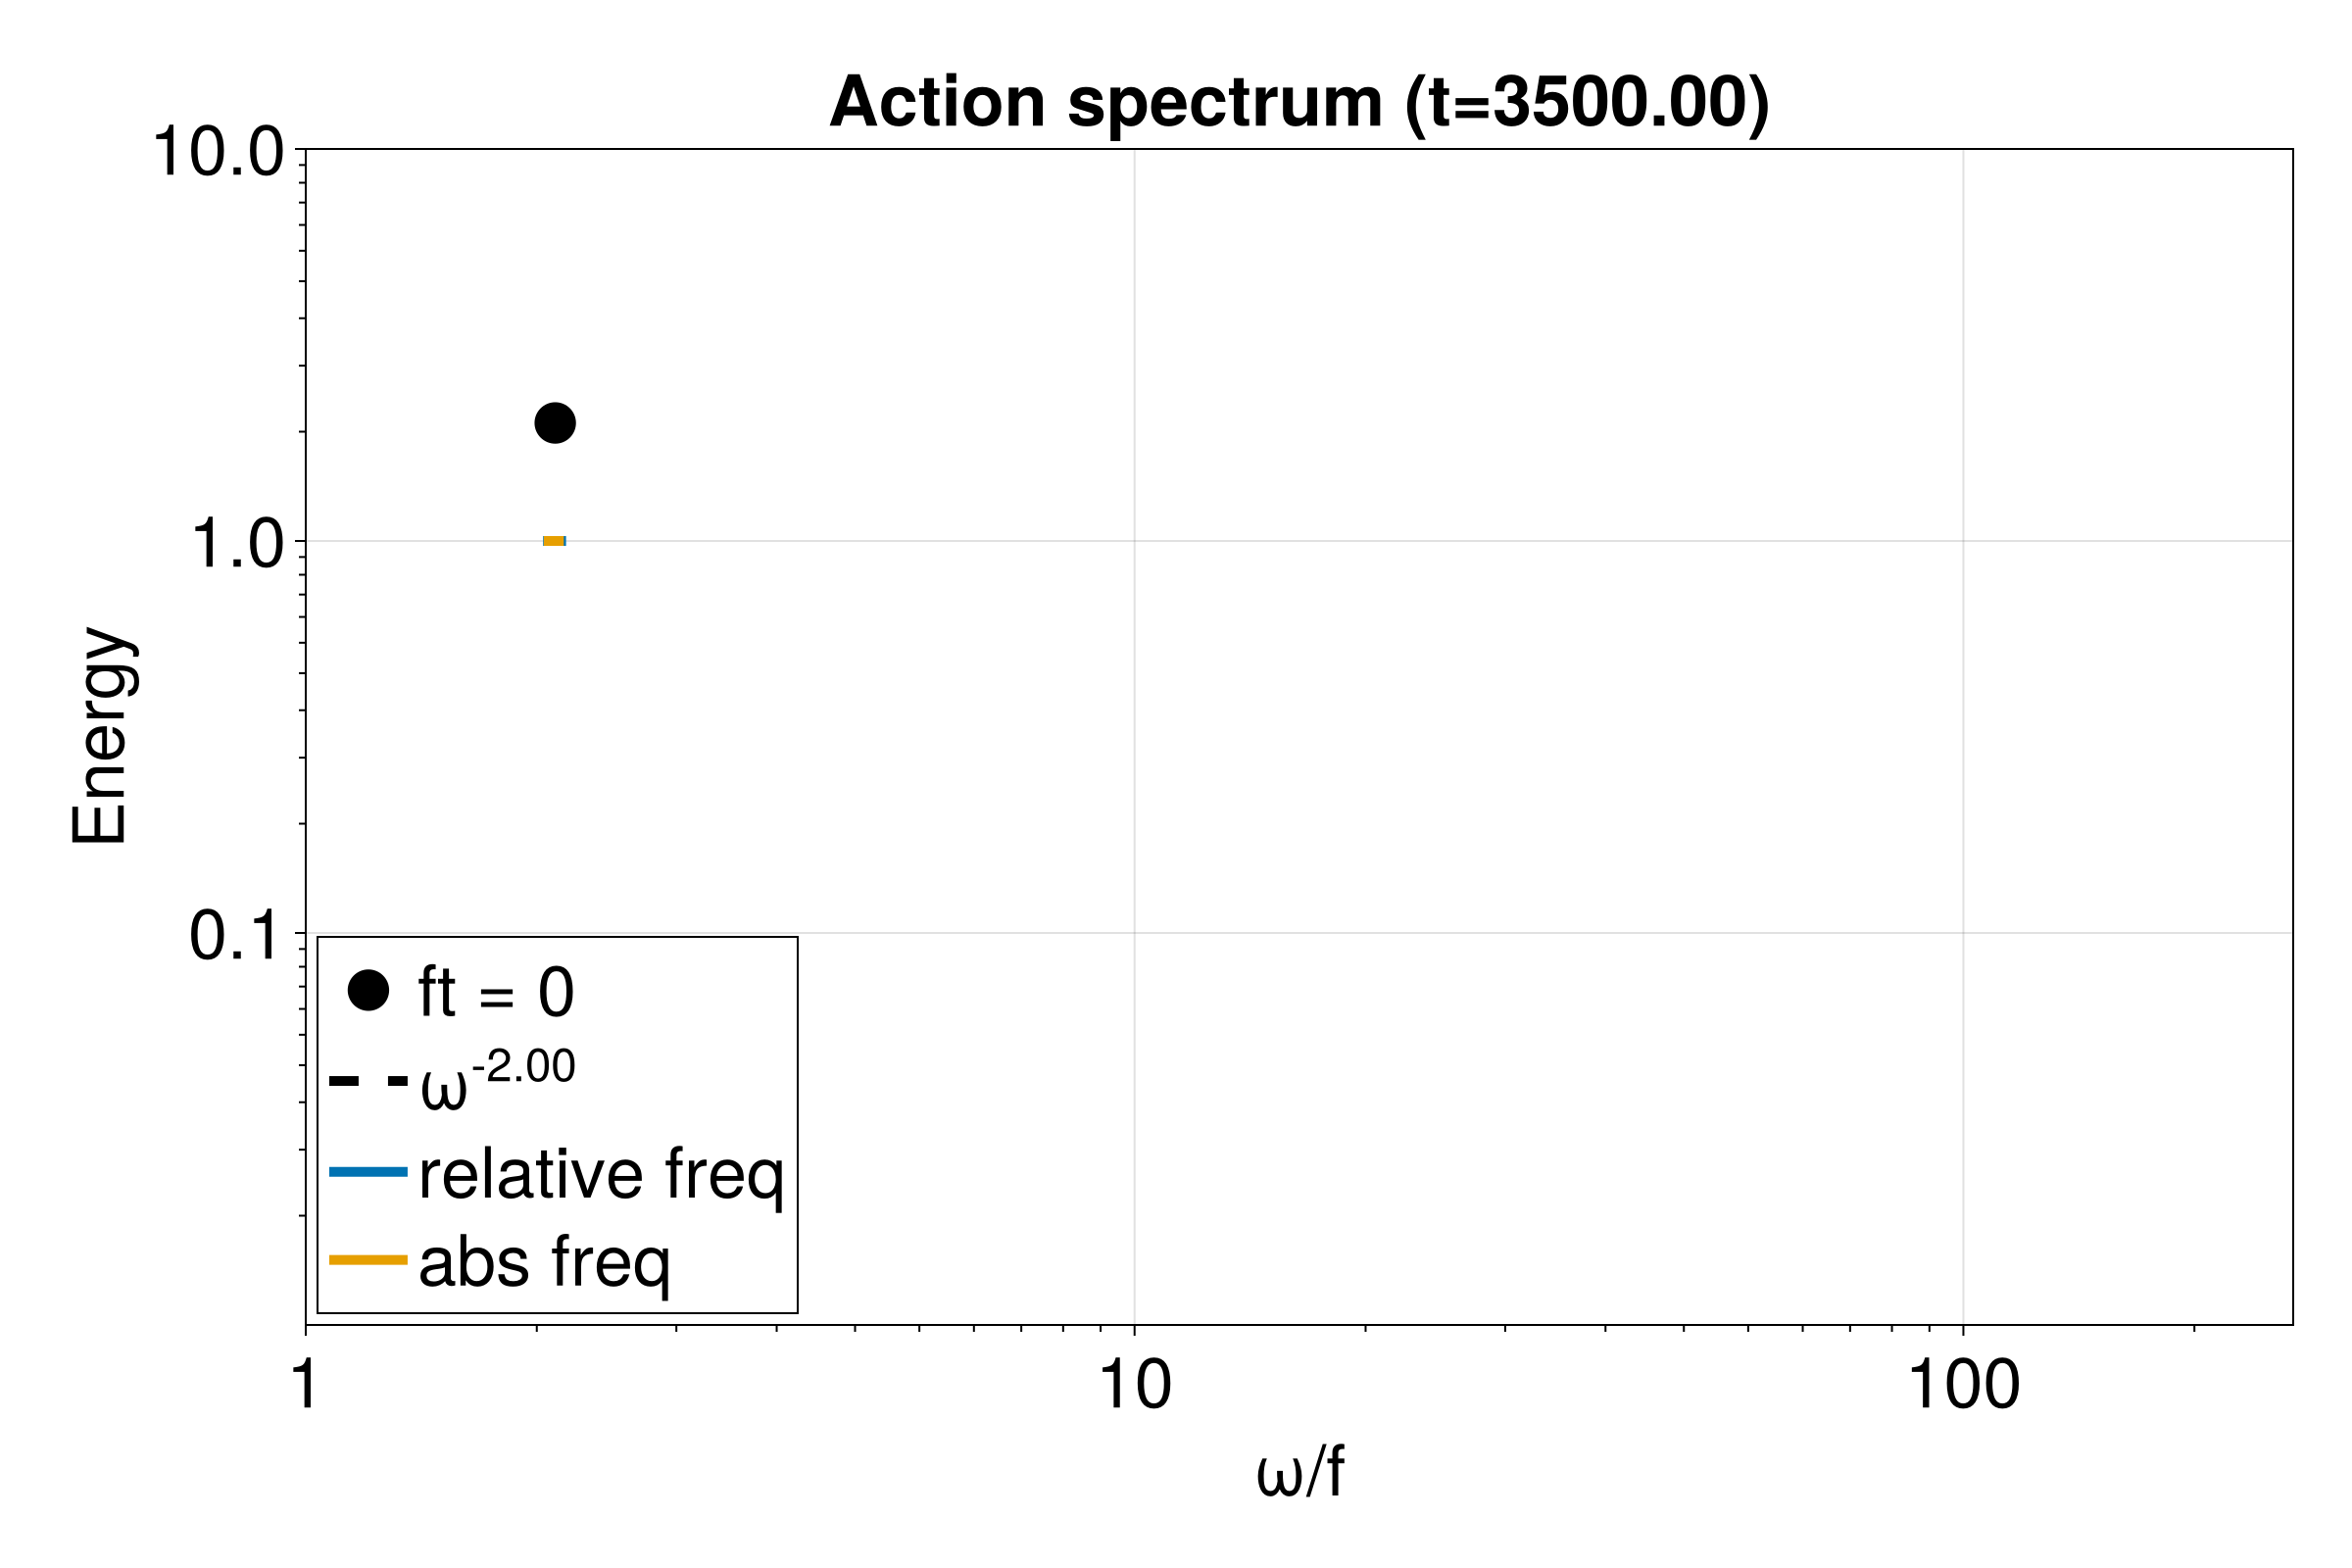

In [15]:
t = t1
k = k1
u = u1

ω  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω₀ = @. sqrt(1 + (k[1,:,1]^2 + k[1,:,2]^2))# + u[1,:,1]*k[1,:,1] + u[1,:,2]*k[1,:,2]
ω_abs  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]

function find_index(time, t, size)
    idx = findfirst(x -> x >= (time), t)[1]
    return idx - Int(floor(size/2))
end

function compute_energy(fω, start, fin, step)
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
end

using Printf
title = Observable(@sprintf("Energy spectrum (t=%.2f)", 0.))
fig3 = Figure(size=(1200, 800), fontsize=36, figure_padding=30)
ax3 = Axis(fig3[1, 1], xscale = log10, yscale = log10, 
        title = title,
        xlabel = "ω/f",
        ylabel = "Energy",
        limits = ((1, 250), (1e-2, 10)),
        yticks = [0.1, 1., 10.],
        xminorticks = IntervalsBetween(10),
        xminorticksvisible=true,
        yminorticks = IntervalsBetween(10),
        yminorticksvisible=true,
        xticks = ([1, 10, 100], ["1", "10", "100"]))
start_w = 1
fin_w = 1
ω_trend = start_w:0.1:fin_w
# slope = -2.25
slope = -2.00
trend = ω₀[1]*(1/3.5)^(slope)*ω_trend.^(slope)

N_lines = 1
#desired_times = [100., 300., 600., 900., 1200., 1500., 1800., 2100., 2400., 2700.]

#desired_times = [2900.]
step_end = 1
get_index(time) = find_index(time, t, step_end)
#starts = get_index.(desired_times)
#starts = [1, 10000, 30000, 50000, 70000]
#ends = starts .+ step_end
step = 1

initial_value_dot = scatter!(ax3, ω₀[1], ω₀[1], color="black", label="ft = 0", markersize=30, marker=:circle)
translate!(initial_value_dot, 0, 0, 1)

time_step = 500
frames = 1:floor(Int, maximum(t) / time_step-1)
println(frames[end])
lines!(ax3, ω_trend, trend, color="black", linestyle=:dash, label=rich("ω", superscript(@sprintf("%.2f", slope))); linewidth=5)
fω_plot = Observable([1.])
fω_abs_plot = Observable([1.])
energy_plot = Observable([1.])
energy_abs_plot = Observable([1.])
lines!(ax3, fω_plot, energy_plot, xscale=:log10, yscale=:log10; linewidth=5, label="relative freq")#, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
lines!(ax3, fω_abs_plot, energy_abs_plot, xscale=:log10, yscale=:log10; linewidth=5, label="abs freq")#, linestyle=:dash, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
axislegend(ax3, position=:lb, patchsize=(40., 20.))
println(length(frames))
CairoMakie.record(fig3, "action_spectrum_movie_U=1.mp4", frames, framerate = 18) do j
    desired_time =  j*time_step
    get_index(time) = find_index(desired_time, t, step_end)
    start = get_index(desired_time)
    ei = start + step_end
    #start = starts[i]
    #ei = ends[i]
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
    energy = sum(mask,dims=2)[:] / length(fω)
    
    fω_abs = sort(ω_abs[start:step:ei,:][:])
    mask = (fω_abs' .>= (fω_abs .- 1)) .* (fω_abs' .<= (fω_abs .+ 1))
    energy_abs = sum(mask,dims=2)[:] / length(fω_abs)
    
    fω_plot[] = fω
    fω_abs_plot[] = fω_abs
    energy_plot[] = energy
    energy_abs_plot[] = energy_abs
    title[] = @sprintf("Action spectrum (t=%.2f)", desired_time)
end


save("action_plot_barotropic_U=1.png", fig3)
fig3

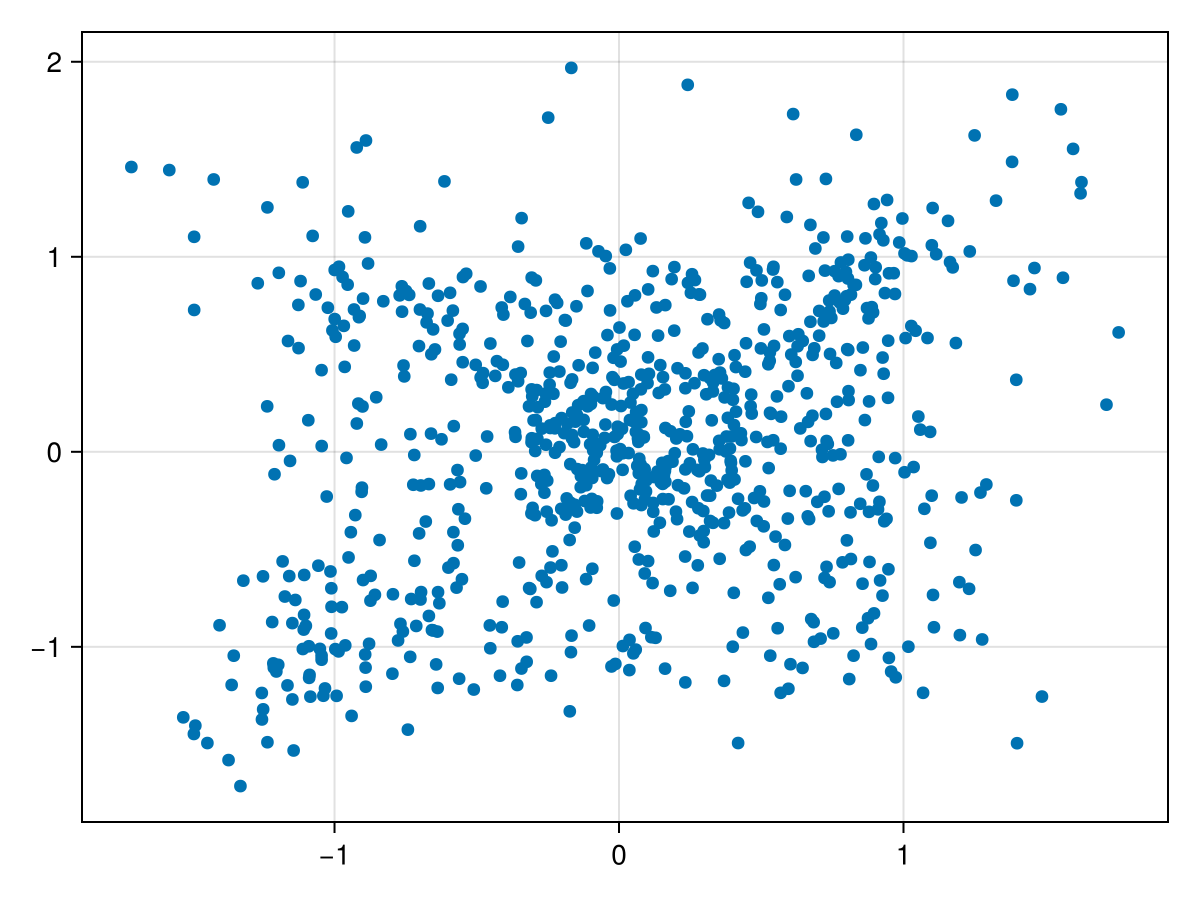

In [120]:
x = zeros((2, 2, 2))
y = zeros((2, 2, 2))

2×2×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0

[:, :, 2] =
 0.0  0.0
 0.0  0.0

In [125]:
sum(x, dims=(3,))

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0

In [136]:
theme_palette(:auto).colors.colors[3]

LoadError: UndefVarError: `theme_palette` not defined

In [155]:
test = t[10000:40:40000]
println(sum(test)/length(test))
println((t[40000] + t[10000])/2)

306.78388573056446
306.7838857305583


In [38]:
using Distributions

LoadError: ArgumentError: Package Distributions not found in current path.
- Run `import Pkg; Pkg.add("Distributions")` to install the Distributions package.